In [2]:
# Business Objective: To predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months.

In [3]:
# Importing neccessary libraries for Data Preparation
import numpy as np
import pandas as pd

In [4]:
# PROCESS - 1   DATA PREPARATION
# Using numpy and panda library for EDA, Feature Engineering and Filtering High-Value Customers.

In [5]:
# Importing the Dataset
df = pd.read_csv('telecom_churn_data.csv')

In [6]:
# Exploring the dataset
print(df.shape)
df.dtypes.value_counts()

(99999, 226)


float64    179
int64       35
object      12
Name: count, dtype: int64

In [7]:
# Removing the columns with only one unique value to improve data quality for analysis.
df.nunique().sort_values()

std_ic_t2o_mou_6        1
std_og_t2c_mou_8        1
std_og_t2c_mou_9        1
std_ic_t2o_mou_9        1
std_ic_t2o_mou_8        1
                    ...  
arpu_9              79937
arpu_8              83615
arpu_7              85308
arpu_6              85681
mobile_number       99999
Length: 226, dtype: int64

In [8]:
unique_cols = df.nunique()
one_value_cols = unique_cols[unique_cols == 1].index
print("Columns with only one unique value:", list(one_value_cols))

Columns with only one unique value: ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9']


In [9]:
# Removing the columns with only one unique value to improve data quality for analysis.
df = df.drop(columns=one_value_cols)

In [10]:
df.shape

(99999, 210)

In [11]:
# Converting the day of last recharge column into date-time format.
date_cols = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9']
df[date_cols] = df[date_cols].apply(pd.to_datetime, errors='coerce')

In [12]:
# Use the max date in the dataset as the reference date
reference_date = df[date_cols].max().max()  

# Calculate days since last recharge
for col in date_cols:
    df[f'days_since_last_{col[-1]}'] = (reference_date - df[col]).dt.days

In [13]:
df['days_since_last_rech'] = df[f'days_since_last_{col[-1]}']

In [14]:
print(df[[f'days_since_last_{col[-1]}' for col in date_cols]].isna().any(axis=1).sum())

8680


In [15]:
# Creating a column 'df['avg_rech_amt_6_7']' to identify High-Value customers and setting threshold value (>=threshold).
df['avg_rech_amt_6_7'] = df[['total_rech_amt_6', 'total_rech_amt_7']].mean(axis=1)  # Average recharge amount across June and July
threshold = np.percentile(df['avg_rech_amt_6_7'], 70)

In [16]:
# Filtering high-value customers (High-Value customers given name X) based on the set threshold.
X = df[df['avg_rech_amt_6_7'] >= threshold]
print(f"Number of high-value customers: {X.shape[0]}")

Number of high-value customers: 30011


In [17]:
# Begining by tagging churners.
# Ensuring we're working with a copy.
X = X.copy()

# Step 2: Taggibg churners safely using .loc
X.loc[:, 'churn'] = ((X['total_og_mou_9'] == 0) & 
                    (X['total_ic_mou_9'] == 0) & 
                    (X['vol_2g_mb_9'] == 0) & 
                    (X['vol_3g_mb_9'] == 0)).astype(int)

In [18]:
# Tagged churners. Removing all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).
X = X[X.columns[~X.columns.str.endswith('_9')]]

In [19]:
# Displaying churn distribution
print(X['churn'].value_counts(normalize=True) * 100)
print(f"Final shape after removing churn phase columns: {X.shape}")

churn
0    91.359835
1     8.640165
Name: proportion, dtype: float64
Final shape after removing churn phase columns: (30011, 165)


In [20]:
print(X.columns)

Index(['mobile_number', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       'offnet_mou_8',
       ...
       'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g',
       'days_since_last_6', 'days_since_last_7', 'days_since_last_8',
       'days_since_last_rech', 'avg_rech_amt_6_7', 'churn'],
      dtype='object', length=165)


In [21]:
# We have 'onnet' and 'offnet'. Any one can give us if they are on or off. So let us remove 3 colums from X.columns.
# This will help avoid multicollinearity.

In [22]:
columns_to_drop = ['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8'] 
X = X.drop(columns=columns_to_drop, errors='ignore')

# Print remaining columns
print(X.columns)

Index(['mobile_number', 'arpu_6', 'arpu_7', 'arpu_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8',
       ...
       'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g',
       'days_since_last_6', 'days_since_last_7', 'days_since_last_8',
       'days_since_last_rech', 'avg_rech_amt_6_7', 'churn'],
      dtype='object', length=162)


In [23]:
# Adding days since last recharge and removing the date-time column.
X['days_since_last_rech'] = df['days_since_last_rech']

# Remove date columns from X
X = X.drop(columns=date_cols, errors='ignore')

In [24]:
# Print remaining columns
print(X.columns)
# Print remaining columns
print(len(X.columns))

Index(['mobile_number', 'arpu_6', 'arpu_7', 'arpu_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8',
       ...
       'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g',
       'days_since_last_6', 'days_since_last_7', 'days_since_last_8',
       'days_since_last_rech', 'avg_rech_amt_6_7', 'churn'],
      dtype='object', length=159)
159


In [25]:
# Checking for missing values to handle them.
print(X.isnull().sum().sum())  # Total missing values
print(X.isnull().sum().sort_values(ascending=False).head(20))  

594318
night_pck_user_6            18614
arpu_2g_6                   18614
count_rech_3g_6             18614
max_rech_data_6             18614
arpu_3g_6                   18614
fb_user_6                   18614
av_rech_amt_data_6          18614
date_of_last_rech_data_6    18614
count_rech_2g_6             18614
total_rech_data_6           18614
total_rech_data_7           18349
av_rech_amt_data_7          18349
max_rech_data_7             18349
count_rech_3g_7             18349
date_of_last_rech_data_7    18349
night_pck_user_7            18349
arpu_3g_7                   18349
fb_user_7                   18349
arpu_2g_7                   18349
count_rech_2g_7             18349
dtype: int64


In [26]:
# Filling missing va;ues with 0 
# Telecom data might lose valuable information if missing values are removed.
X = X.fillna(0)
print(X.isnull().sum().sum())  # Should print 0 if all missing values are filled

0


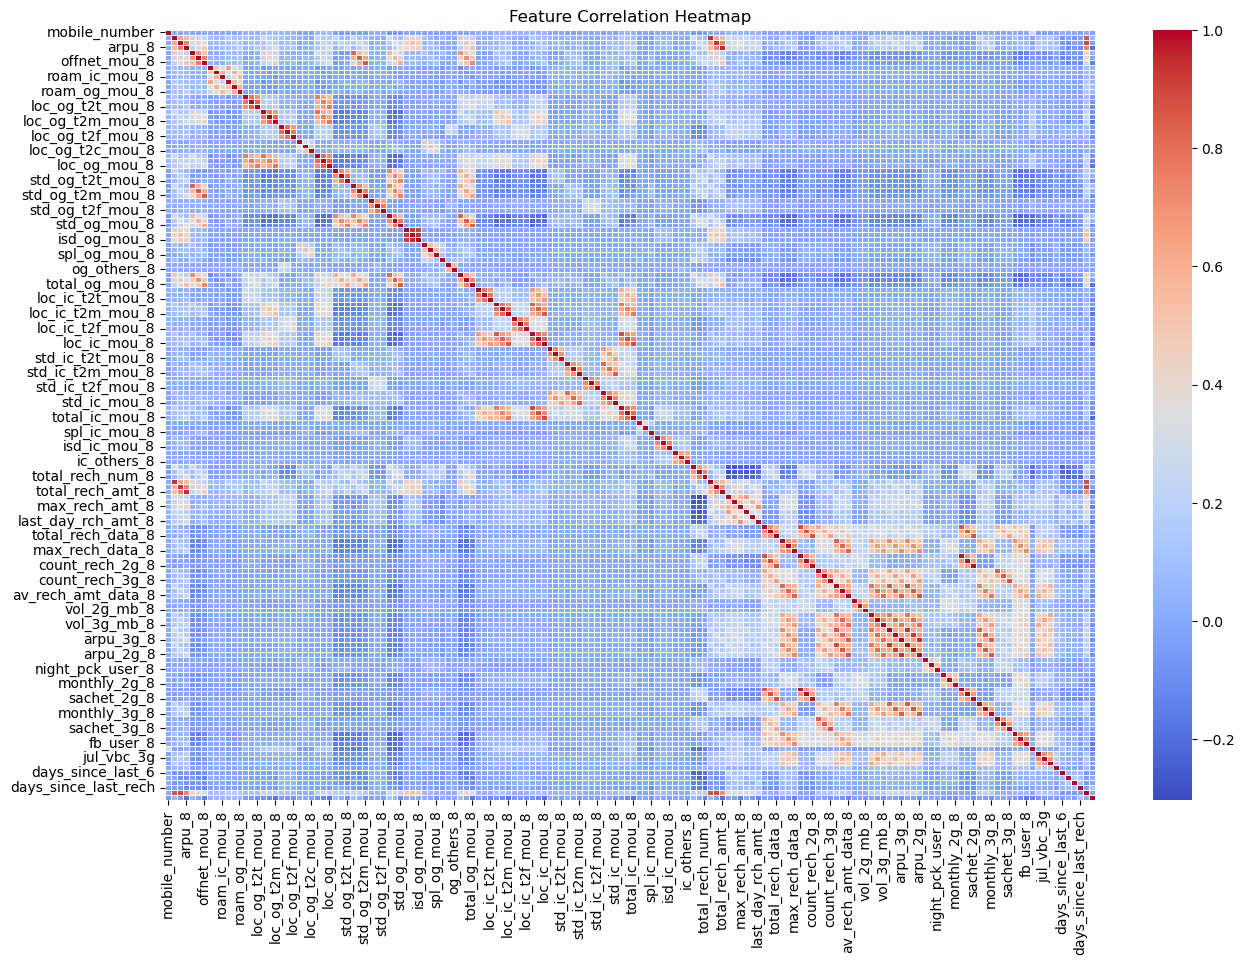

In [27]:
# Plotting a heatmap to see the correlation between variables.
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation calculation
X_numeric = X.select_dtypes(include=['number'])

# Plot correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(X_numeric.corr(), cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [28]:
# Running the correlation analysis on X_numeric.
corr_matrix = X_numeric.corr().abs()  
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  
high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]  

print(f"Number of highly correlated columns: {len(high_corr_features)}")
print(high_corr_features)  # List of features to be removed

Number of highly correlated columns: 49
['loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_7', 'loc_og_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'isd_og_mou_7', 'isd_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'vol_3g_mb_7', 'vol_3g_mb_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'avg_rech_amt_6_7']


In [29]:
# Dropping highly correlated columns.
X = X.drop(columns=high_corr_features, errors='ignore')

print(f"Shape after removing highly correlated features: {X.shape}")

Shape after removing highly correlated features: (30011, 110)


In [30]:
# Checking for missing values.
missing_values = X.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Only show columns with missing values

print(f"Number of columns with missing values: {len(missing_values)}")
print(missing_values)

Number of columns with missing values: 0
Series([], dtype: int64)


In [ ]:
# PROCESS - 2   DATA MODELLING
# Using sklearn libraries and statsmodels libraries for data modelling.

In [31]:
from sklearn.preprocessing import StandardScaler

# Selecting only numeric columns (excluding 'churn')
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('churn')  # Keep churn column separate

# Initializing scaler
scaler = StandardScaler()

# Scaling only numeric features
X_scaled = scaler.fit_transform(X[numeric_cols])

# Convert back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=numeric_cols)

# Adding 'churn' column back
X_scaled['churn'] = X['churn'].values

print("Feature scaling completed!")

Feature scaling completed!


In [32]:
# Using variance threshold followed by VIF for better data modelling
# This will help reduce multicollinearity

from sklearn.feature_selection import VarianceThreshold

# Applying Variance Threshold (removing features with near-zero variance)
selector = VarianceThreshold(threshold=0.01)  # You can adjust the threshold if needed
X_reduced = selector.fit_transform(X_scaled.drop(columns=['churn']))

# Getting selected feature names
selected_features = X_scaled.drop(columns=['churn']).columns[selector.get_support()]

# Convert back to DataFrame
X_reduced = pd.DataFrame(X_reduced, columns=selected_features)

# Adding 'churn' column back
X_reduced['churn'] = X_scaled['churn']

print(f"Shape after removing low-variance features: {X_reduced.shape}")

Shape after removing low-variance features: (30011, 107)


In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF and drop highly collinear features
def remove_high_vif_features(X, threshold=5.0):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    while vif_data["VIF"].max() > threshold:
        highest_vif_feature = vif_data.loc[vif_data["VIF"].idxmax(), "Feature"]
        print(f"Dropping {highest_vif_feature} with VIF: {vif_data['VIF'].max():.2f}")
        
        X = X.drop(columns=[highest_vif_feature])
        
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return X

In [34]:
# Applying VIF elimination
X_final = remove_high_vif_features(X_reduced, threshold=5.0)

print(f"Final shape after removing multicollinear features: {X_final.shape}")

Dropping loc_og_mou_6 with VIF: 4096894741.08
Dropping loc_og_mou_7 with VIF: 1376.33
Dropping std_og_mou_7 with VIF: 427.22
Dropping std_og_mou_6 with VIF: 309.03
Dropping std_og_mou_8 with VIF: 27.36
Dropping arpu_8 with VIF: 5.94
Dropping offnet_mou_7 with VIF: 5.26
Dropping total_rech_data_7 with VIF: 5.12
Dropping max_rech_data_6 with VIF: 5.06
Final shape after removing multicollinear features: (30011, 98)


In [47]:
X.dtypes

mobile_number             int64
arpu_6                  float64
arpu_7                  float64
arpu_8                  float64
offnet_mou_6            float64
                         ...   
sep_vbc_3g              float64
days_since_last_6       float64
days_since_last_7       float64
days_since_last_8       float64
days_since_last_rech    float64
Length: 109, dtype: object

In [49]:
X = X.astype({col: 'int32' for col in X.select_dtypes(include=['float']).columns})

In [55]:
print(X.select_dtypes(include=['object']).columns)

Index(['date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8'],
      dtype='object')


In [56]:
X = X.select_dtypes(exclude=['object'])

In [70]:
y = y.drop(columns=['mobile_number', 'days_since_last_8'])

In [72]:
# Using RandomForest for feature selection and creating a logistic regression model.

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import train_test_split

# Split data (y is the target variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model (RandomForest works well for feature selection)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Applying RFE (Setting n_features_to_select based on how many features is required)
rfe = RFE(model, n_features_to_select=15) 
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

In [59]:
print(X_train.dtypes)

mobile_number           int64
arpu_6                  int32
arpu_7                  int32
arpu_8                  int32
offnet_mou_6            int32
                        ...  
sep_vbc_3g              int32
days_since_last_6       int32
days_since_last_7       int32
days_since_last_8       int32
days_since_last_rech    int32
Length: 106, dtype: object


In [60]:
# Dropping mobile_number and any date-related columns.
X_train = X_train.drop(columns=['mobile_number'], errors='ignore')
X_test = X_test.drop(columns=['mobile_number'], errors='ignore')

In [61]:
# Identifying columns with non-numeric values.
non_numeric_columns = X_train.select_dtypes(exclude=['number']).columns
print("Columns with non-numeric values:", non_numeric_columns)

Columns with non-numeric values: Index([], dtype='object')


In [ ]:
print("Columns with non-numeric values:", non_numeric_columns)

In [65]:
print(X_train.dtypes.unique())

[dtype('int32') dtype('int64')]


In [73]:
# Getting selected feature names.
selected_features = X.columns[rfe.support_]
print(f"Selected Features: {selected_features}")

Selected Features: Index(['arpu_6', 'arpu_7', 'arpu_8', 'offnet_mou_6', 'offnet_mou_7',
       'offnet_mou_8', 'roam_og_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_7',
       'max_rech_amt_8', 'aon', 'days_since_last_rech'],
      dtype='object')


In [74]:
# Making sure training (X_train_rfe) and testing (X_test_rfe) datasets contain only the selected features:
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

In [76]:
# Training a machine learning model using the selected features:
from sklearn.ensemble import RandomForestClassifier

# Initializing the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
model.fit(X_train_rfe, y_train)

RandomForestClassifier(random_state=42)

In [77]:
# Using sklearn metrics to predict model accuracy.

from sklearn.metrics import accuracy_score, classification_report

# Make predictions
y_pred = model.predict(X_test_rfe)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.9414
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      5476
           1       0.75      0.50      0.60       527

    accuracy                           0.94      6003
   macro avg       0.85      0.74      0.78      6003
weighted avg       0.94      0.94      0.94      6003



In [ ]:
# The Model Accuracy is 0.94, which is good. But, the data is imbalanced.
# Handling class imbalance and then retesting the model.

In [95]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)

In [96]:
# Training Logistic Regression Again.
from sklearn.linear_model import LogisticRegression

# Train the model
model = LogisticRegression(class_weight='balanced', solver='saga', max_iter=5000, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = model.predict(X_test_scaled)


In [97]:
from sklearn.metrics import classification_report, accuracy_score

print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.8234216225220723
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      5476
           1       0.31      0.82      0.45       527

    accuracy                           0.82      6003
   macro avg       0.64      0.82      0.67      6003
weighted avg       0.92      0.82      0.86      6003



In [ ]:
# The accuracy is 0.82, but the data imbalance still exists in the model.
# Using RandonForest to create another model to check if the precdiction increases.

In [99]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)


In [100]:
rf_model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

y_pred_rf = rf_model.predict(X_test_scaled)

print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      5476
           1       0.60      0.69      0.64       527

    accuracy                           0.93      6003
   macro avg       0.78      0.82      0.80      6003
weighted avg       0.94      0.93      0.93      6003



In [ ]:
# The prediction is 60% correct and has lesser data imbalance thanthe previous model which was 31% correct and had class imbalance.
# We are taking this model to see which feature impacts churrn.

In [ ]:
# Feature Importance Analysis
# To understand which features impact churn the most, extract feature importances:

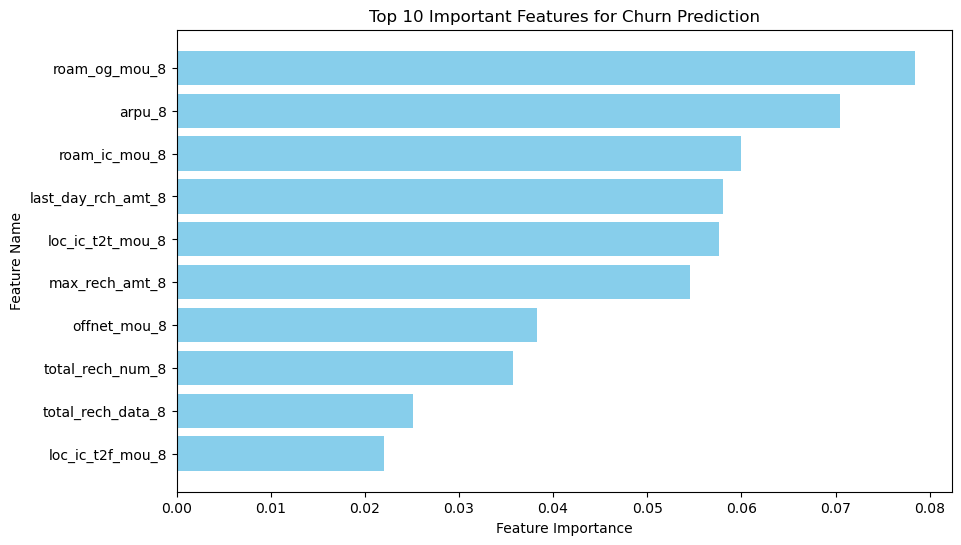

In [101]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame
feat_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort by importance
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10,6))
plt.barh(feat_importance_df['Feature'][:10], feat_importance_df['Importance'][:10], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 10 Important Features for Churn Prediction")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [ ]:
# We have taken top 10 features that predict churn. 
# The prediction suggests that roam_ic_mou_8 has the hightest importance in predictiong churn rate.

In [ ]:
# PREDICTIONS

# The 8th month has been very important to identify customers who are likely to churn.
# This month is the 'action phase'.

# Identifying the usage statistics of customer after good phase is very important in the likelihood of churn.
# We need to create a model where a customers good phase is detected.
# When the usage statistics of the cuustomer is likely starting to match with the action phase, that customer is likely to churn.

# The reason for churn can be 
#  - Offer from other network  : Compare the previous recharges done with the other network to give better offers and retain customer.
#  - Signal problem            : Compare the roaming call and see the average time spent on call. If the average is less and reason is signal, 
#                                improve signal in that particular area.
#  - Data                      : Check data usage. If the person uses data or not. If data not used, use demographic factors to identify the person and 
#                                give related offers. If the data usage is less or has become less over a period of time, then check for network strenght.
#                                Check if the tower has changed. Improve the signal. (Take this as a call to improve network at that area)

# Handling of the data like a stock market prediction is must. 
# Analyse usase pattern to identify the three phases to take action during the action phase to avoid churn.